In [1]:
## 데이터 보기
import pandas as pd
 
df = pd.read_csv('ecommerce-data.csv', encoding = 'ISO-8859-1') ## 인코딩 지정 안해주면 에러남

In [2]:
## 칼럼보기
for col in df.columns:
    print(col)

InvoiceNo
StockCode
Description
Quantity
InvoiceDate
UnitPrice
CustomerID
Country


In [3]:
## 기간 보기
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) ## 문자열로된 날짜를 Timestamp형식으로 변환
 
set_of_year_month = list(set([(x.year, x.month) for x in df['InvoiceDate']])) ## 송장날짜에서 연도와 월정보를 가져온다.
for ym in sorted(set_of_year_month, key=lambda x: (x[0], x[1])): ## 연도와 월정보를 연도, 월 순으로 출력 
    print(f'{ym[0]}년 {ym[1]}월')

2010년 12월
2011년 1월
2011년 2월
2011년 3월
2011년 4월
2011년 5월
2011년 6월
2011년 7월
2011년 8월
2011년 9월
2011년 10월
2011년 11월
2011년 12월


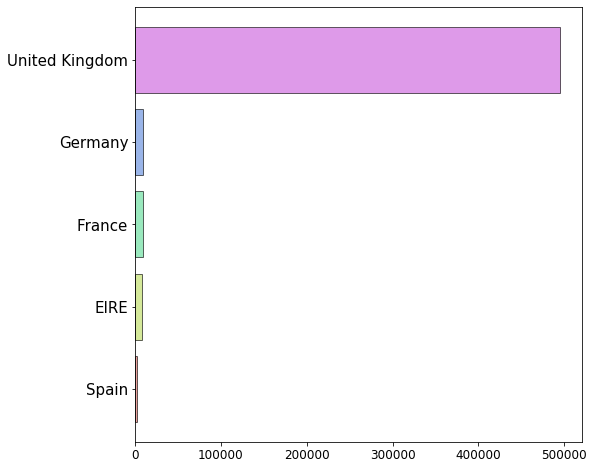

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
 
nation_data = Counter(df['Country']).most_common() ## 데이터 개수가 많은 순으로 출력
nation_data = nation_data[:5] ## 상위 5개만 저장
 
data = [x[1] for x in nation_data] ## 데이터 개수
nations = [x[0] for x in nation_data] ## 국가
 
## 수평 바차트에서 데이터 개수와 나라를 맨위로 출력하기 위해서 리스트 순서를 바꿈
nations.reverse()
data.reverse()
 
## 시각화
fig =plt.figure(figsize=(8,8))
 
fig.set_facecolor('white') ## 캔버스 색깔
colors = sns.color_palette('hls',len(data)) ## color 생성
plt.yticks(fontsize=15) # y축 눈금 라벨 폰트사이즈 설정
plt.xticks(fontsize=12) # x축 눈금 라벨 폰트사이즈 설정
 
plt.barh(nations, data, color=colors,alpha=0.6,edgecolor='k') ## 수평바차트 생성
plt.show()

In [5]:
######### 데이터 전처리
import pandas as pd
 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) ## 문자열로된 날짜를 Timestamp형식으로 변환
 
## 분석할 나라와 연도 설정
target_country = 'United Kingdom'
target_year = '2011'
 
df = df.query('Country == @target_country and InvoiceDate.dt.year == @target_year')
 
## 필요한 칼럼 추출
df = df[['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']]
 
## 결측값 처리
df = df.dropna()
 
## 구매 취소 데이터 삭제
 
## 송장번호 앞에 'C'가 있으면 삭제 구매취소된 데이터를 의미한다. 여기서는 단순히 'C'가 있는지 없는지만 보면된다.
df = df.query('InvoiceNo.str.get(0) != "C"')

In [6]:
######### 데이터 분석
import pandas as pd
from tqdm import tqdm
 
customer_id = list(df['CustomerID'].unique()) ## 고객아이디
 
## 먼저 각 고객별로 구매금액이 얼마인지 알아보자.
monetary_df = pd.DataFrame() ## 구매금액 데이터 초기화
monetary_df['CustomerID'] = customer_id ## 고객아이디 삽입
 
monetary_data = [] ## 구매금액을 담을 리스트
for ci in tqdm(customer_id,position=0,desc='Calculating amount of individual customer'):
    temp = df.query('CustomerID==@ci') ## 해당 아이디의 고객데이터 추출
    amount = sum(temp['Quantity'] * temp['UnitPrice']) ## 해당 고객 구매금액
    monetary_data.append(amount)
    
monetary_df['Monetary'] = monetary_data ## 구매금액 데이터 삽입
 
## 각 고객별 최근방문일을 알아보자.
temp_recency_df = df[['CustomerID','InvoiceDate']].drop_duplicates() ## 고객 아이디와 송장날짜만 추출한뒤 중복 제거
recency_df = temp_recency_df.groupby('CustomerID')['InvoiceDate'].max().reset_index() ## 아이디로 그룹화 한다음 최근방문일을 구해야 하므로 송장날짜에 max를 적용한다.
recency_df = recency_df.rename(columns={'InvoiceDate':'Recency'})
 
## 각 고객별 방문횟수를 알아보자.
temp_frequency_df = df[['CustomerID','InvoiceNo']].drop_duplicates() ## 고객 아이디와 송장번호만 추출한뒤 중복 제거
frequency_df = temp_frequency_df.groupby('CustomerID')['InvoiceNo'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 송장번호 개수로 생각했으므로 송장번호에 count를 적용한다.
frequency_df = frequency_df.rename(columns={'InvoiceNo':'Frequency'})
 
## 데이터를 고객아이디를 기준으로 합쳐야한다.
rfm_df = pd.merge(recency_df,frequency_df,how='left',on='CustomerID')
rfm_df = pd.merge(rfm_df,monetary_df,how='left',on='CustomerID')

Calculating amount of individual customer: 100%|██████████████████████████████████| 3814/3814 [00:27<00:00, 138.66it/s]


In [7]:
## 데이터 변환
current_day = pd.to_datetime('20110101') ## 기준 날짜를 2011년 1월 1일 0시 0분으로 잡았다.

time_diff = rfm_df['Recency']-current_day ## 최근방문일과 기준 날짜의 시간 차이
time_in_seconds = [x.total_seconds() for x in time_diff] ## 시간 차이를 초단위로 계산
rfm_df['Recency'] = time_in_seconds ## 변환된 데이터를 다시 삽입한다.
rfm_df

2011-01-01 00:00:00


,CustomerID,Recency,Frequency,Monetary
0,12346.0,1504860.0,1,77183.60
1,12747.0,29428440.0,9,3489.74
2,12748.0,29593200.0,175,29491.60
3,12749.0,29325360.0,5,4090.88
4,12820.0,29344320.0,4,942.34
5,12821.0,11116260.0,1,92.72
6,12822.0,23537040.0,2,948.88
7,12823.0,23182500.0,5,1759.50
8,12824.0,24497340.0,1,397.12
9,12826.0,29413500.0,6,1319.72


In [12]:
def get_score(level, data):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue 
    return score
    
def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    '''
    Description :
    개별 고객에 대한 최근방문일/방문횟수/구매금액 데이터가 주어졌을때
    최근방문일/방문횟수/구매금액 점수를 계산하여 주어진 데이터 오른쪽에 붙여줍니다.
    
    Parameters :
    df = pandas.DataFrame 데이터
    num_class = 등급(점수) 개수
    rfm_tick_point = 최근방문일/방문횟수/구매금액에 대해서 등급을 나눌 기준이 되는 값
                    'quantile', 'min_max' 또는 리스트를 통하여 직접 값을 정할 수 있음.
                    단, 리스트 사용시 원소의 개수는 반드시 num_class - 1 이어야함.
                    quatile = 데이터의 분위수를 기준으로 점수를 매김
                    min_max = 데이터의 최소값과 최대값을 동일 간격으로 나누어 점수를 매김
    rfm_col_map = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명
    예 - {'R':'Recency','F':'Frequency','M':'Monetary'}
    suffix = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명 뒤에 붙는 접미사
    Return : 
    pandas.DataFrame
    '''
    ##### 필요모듈 체크
    import pandas as pd
    import numpy as np
    from sklearn import preprocessing
    
    ##### 파라미터 체크
    if not isinstance(df, pd.DataFrame): ## 데이터는 pd.DataFrame이어야 함.
        print('데이터는 pandas.DataFrame 객체여야 합니다.')
        return
    
    if isinstance(rfm_tick_point, dict) == False or isinstance(rfm_col_map, dict) == False: ## rfm_tick_point와 rfm_col_map은 모두 딕셔너리
        print(f'rfm_tick_point와 rfm_col_map은 모두 딕셔너리여야합니다.')
        return
    
    if len(rfm_col_map) != 3: ## rfm_col_map에는 반드시 3개의 키를 가져아함.
        print(f'rfm_col_map인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if len(rfm_tick_point) != 3: ## rfm_tick_point에는 반드시 3개의 키를 가져아함.
        print(f'rfm_tick_point인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if set(rfm_tick_point.keys()) != set(rfm_col_map.keys()): ## rfm_tick_point와 rfm_col_map은 같은 키를 가져야함.
        print(f'rfm_tick_point와 rfm_col_map은 같은 키를 가져야 합니다.')
        return
    
    if not set(rfm_col_map.values()).issubset(set(df.columns)):
        not_in_df = set(rfm_col_map.values())-set(df.columns)
        print(f'{not_in_df}이 데이터 칼럼에 있어야 합니다.')
        return
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if not v in ['quantile','min_max']:
                print(f'{k}의 값은 "quantile" 또는 "min_max"중에 하나여야 합니다.')
                return
        elif isinstance(v,list) or isinstance(v,tuple):
            if len(v) != num_class-1:
                print(f'{k}에 대응하는 리스트(튜플)의 원소는 {num_class-1}개여야 합니다.')
                return
    
    if suffix:
        if not isinstance(suffix, str):
            print('suffix인자는 문자열이어야합니다.')
            return
        
    ##### 최근방문일/방문횟수/구매금액 점수 부여
    for k, v in rfm_tick_point.items():
        if isinstance(v,str):
            if v == 'quantile':
                ## 데이터 변환
                scale = preprocessing.StandardScaler() ## 데이터의 범위 조작하기 쉽게 해주는 클래스 
                temp_data = np.array(df[rfm_col_map[k]]) ## 데이터를 Numpy 배열로 변환
                temp_data = temp_data.reshape((-1,1)) ## scale을 적용하기위해 1차원 배열을 2차원으로 변환
                temp_data = scale.fit_transform(temp_data) ## 데이터를 평균은 0, 표준편차는 1을 갖도록 변환 
                temp_data = temp_data.squeeze() ## 데이터를 다시 1차원으로 변환
 
                ## 분위수 벡터
                quantiles_level = np.linspace(0,1,num_class+1)[1:-1] ## 분위수를 구할 기준값을 지정 0과 1은 제외
                quantiles = [] ## 분위수를 담을 리스트
                for ql in quantiles_level:
                    quantiles.append(np.quantile(temp_data,ql)) ## 분위수를 계산하고 리스트에 삽입
            else: ## min_max인 경우
                ## 데이터 변환
                temp_data = np.array(df[rfm_col_map[k]])
 
                ## 등분점 계산
                quantiles = np.linspace(np.min(temp_data),np.max(temp_data),num_class+1)[1:-1] ## 최소값과 최대값을 점수 개수만큼 등간격으로 분할하는 점
        else: ## 직접 구분값을 넣어주는 경우
            temp_data = np.array(df[rfm_col_map[k]])
            quantiles = v ## 직접 구분값을 넣어줌
        score = get_score(quantiles, temp_data) ## 구분값을 기준으로 점수를 부여하고 리스트로 저장한다.
        new_col_name = rfm_col_map[k]+'_'+k ## 점수값을 담는 변수의 이름
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
        df[new_col_name] = score ## 기존데이터 옆에 점수 데이터를 추가한다.
    return df



In [13]:
rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}
 
result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result.to_csv('result.csv',index=False)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']] # 결과!

,CustomerID,Recency_R,Frequency_F,Monetary_M
0,12346.0,1,2,5
1,12747.0,5,5,5
2,12748.0,5,5,5
3,12749.0,5,4,5
4,12820.0,5,4,4
5,12821.0,1,2,1
6,12822.0,2,2,4
7,12823.0,2,4,4
8,12824.0,3,2,2
9,12826.0,5,5,4


In [ ]:
rfm_tick_point={'R':'quantile','F':'quantile','M':'min_max'} ## 구매금액에 최소값 최대값을 이용한 방법 적용
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}
 
result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']]

In [ ]:
rfm_tick_point={'R':'quantile','F':[5, 10, 50, 90],'M':'quantile'} ## 방문 횟수에 직접 기준값을 정하는 방법 적용
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}
 
result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']]